In [1]:
from griblib import HARMONIE
from griblib.utils.geo import get_great_circle_path
from griblib.io.ascii import write_profile
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patheffects as pe

import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
from cartopy.feature import BORDERS

from scipy import ndimage
import pandas as pd
import glob

import xarray as xr

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%config Completer.use_jedi = False
%matplotlib inline
import matplotlib.pylab as plt
plt.rcParams['figure.dpi'] = 125

In [4]:
# plotting parameters
temp_lim = {'min': -5.0, 'max': 5.0}
temp_lim = {'min': 10.0, 'max': 25.0}
wind_lim = {'min': 5.0, 'max': 20.0}
z_lim = {'min': 0.0, 'max': 15.0}
P_lim = {'min': 1002, 'max': 1015.0 }
mld_lim = {'min': 0.0, 'max': 5.0e3 }
tke_lim = {'min': 0.1, 'max': 5.0}
rain_lim = {'min': 1.0e-3, 'max': 100.0 }
ptke_lim = {'min': 0.0, 'max': 5.0}

In [5]:
import pandas as pd
# Cabauw and De Bilt

df = pd.DataFrame(
    {'Site': ['NL.CIA', 'NL.DBNI', 'NL.DIA', 'NL.IS311', 'NL.EXL'],
     'Location': ['Cabauw', 'De Bilt', 'Deelen', 'Dwingeloo', 'Exloo'],
     'Latitude': [51.968840, 52.098870, 52.060110, 52.811785, 52.906795],
     'Longitude': [4.927930, 5.175890, 5.887300, 6.394668, 6.865549]
    })
df

Site   Location   Latitude  Longitude
0    NL.CIA     Cabauw  51.968840   4.927930
1   NL.DBNI    De Bilt  52.098870   5.175890
2    NL.DIA     Deelen  52.060110   5.887300
3  NL.IS311  Dwingeloo  52.811785   6.394668
4    NL.EXL      Exloo  52.906795   6.865549

In [6]:
import glob
#fid_grib = 'cy36/20190605_18/HARM_N25_201906051800_00000_GB'
#fid_grib = 'cy36/20190605_21/HARM_N25_201906052100_00000_GB'

#fid_grib = 'cy40/20190605_18/HA40_N25_201906051800_00200_GB'
#fid_grib = 'cy40/20190605_21/HA40_N25_201906052100_00100_GB'
#fid_grib = 'cy40/20190605_21/HA40_N25_201906052100_01200_GB'
gribs = glob.glob('cy40/*/*_GB')
for fid_grib in sorted(gribs):
    print(fid_grib)
    
fid_grib = 'cy40/20190606_00/HA40_N25_201906060000_00000_GB'

cy40/2019060400/HA40_N25_201906040000_00000_GB
cy40/2019060400/HA40_N25_201906040000_00100_GB
cy40/2019060400/HA40_N25_201906040000_00200_GB
cy40/2019060403/HA40_N25_201906040300_00000_GB
cy40/2019060403/HA40_N25_201906040300_00100_GB
cy40/2019060403/HA40_N25_201906040300_00200_GB
cy40/2019060406/HA40_N25_201906040600_00000_GB
cy40/2019060406/HA40_N25_201906040600_00100_GB
cy40/2019060406/HA40_N25_201906040600_00200_GB
cy40/2019060409/HA40_N25_201906040900_00000_GB
cy40/2019060409/HA40_N25_201906040900_00100_GB
cy40/2019060409/HA40_N25_201906040900_00200_GB
cy40/2019060412/HA40_N25_201906041200_00000_GB
cy40/2019060412/HA40_N25_201906041200_00100_GB
cy40/2019060412/HA40_N25_201906041200_00200_GB
cy40/2019060415/HA40_N25_201906041500_00000_GB
cy40/2019060415/HA40_N25_201906041500_00100_GB
cy40/2019060415/HA40_N25_201906041500_00200_GB
cy40/2019060418/HA40_N25_201906041800_00000_GB
cy40/2019060418/HA40_N25_201906041800_00100_GB
cy40/2019060418/HA40_N25_201906041800_00200_GB
cy40/20190604

In [7]:
fid_provinces = '/Users/assink/infrasound/network/maps/NL/GMT/Provinciegrenzen_2018-shp/Provinciegrenzen_2018.shp'
prov2018 = list(shpreader.Reader(fid_provinces).geometries())

In [8]:
# parameters for great circle path
path_params = dict()
path_params['type'] = 'coordinates'
path_params['start'] = dict(lat=50.0, lon=4.0)
path_params['end'] = dict(lat=54.0, lon=7.0)
#path_params['range'] = 700.0e3
#path_params['azimuth'] = 60.0
dr = 1.0e3

(lons, lats, azi, dist) = get_great_circle_path(path_params, dr)
#path_params['end'] = dict(lat=lats[-1], lon=lons[-1])

In [9]:
my_atmos = HARMONIE(cycle='40')

In [10]:
def read_HARMONIE_set_one(self, fid_grid):
    request = [
        {'level_type': 'hybrid', 'var_list': ['u', 'v', 'pdep', 'tke']},
        {'level_type': 'heightAboveSea'},
        {'level_type': 'heightAboveGround', 'var_list': ['ugst', 'vgst', 'mld']}
    ]

    if self.cycle == 36:
        request.append({'level_type': 'heightAboveGround',
                        'var_list': ['tp']})
    else:
        request.append({'level_type': 'heightAboveGround',
                        'var_list': ['rain'], 'step_type': 'instant' })

    ds = self.read_grib(fid_grib, request, compat='override')
    return ds

In [11]:
def read_HARMONIE_set_two(self, fid_grid):
    request = [
        {'level_type': 'heightAboveGround', 'var_list': ['pres', 't'], 'level': 0}
    ]

    ds = self.read_grib(fid_grib, request, verbose=False, compat='override')
    return ds

In [12]:
def read_HARMONIE(self, fid_grib):
    # Read data
    ds = read_HARMONIE_set_one(self, fid_grib)
    ground_level = len(ds.hybrid)

    ds_sfc = read_HARMONIE_set_two(self, fid_grib)
    
    # Wind speed
    ds['windgust_speed'] = np.sqrt(ds.ugst**2+ds.vgst**2)
    #ds.windgusts = windgusts.where(windgusts > 0.95*wind_lim['min'])
    ds.windgust_speed.attrs= {'long_name': 'Wind gust speed',
                                 'units' : 'm/s',
                                 'standard_name': 'wind_gust'}

    ds['wind_speed'] = np.sqrt(ds.u**2+ds.v**2)
    #ds.windgusts = windgusts.where(windgusts > 0.95*wind_lim['min'])
    ds.wind_speed.attrs= {'long_name': 'Wind speed',
                                 'units' : 'm/s',
                                 'standard_name': 'wind'}
    
    # Mean sea level pressure
    ds['pres_msl'] = ds.pres / 1e2
    ds.pres_msl.attrs={'long_name': 'MSL Pressure',
                       'units' : 'hPa',
                       'standard_name': 'MSL Pressure'}

    # Pressure model processing
    pres_msl_deviations = ds.pres_msl - ds.pres_msl.mean()
    # pres_msl_deviations.attrs={'long_name': 'MSL Pres. deviation',
    #                     'units' : 'hPa',
    #                     'standard_name': 'MSL Pres. deviation'}

    lowpass = ndimage.gaussian_filter(pres_msl_deviations.values, 10)
    gauss_highpass = pres_msl_deviations.values - lowpass

    ds['pres_hp'] = ds.pres_msl.copy(data=gauss_highpass).rename('pres_hp')
    ds.pres_hp.attrs = {'long_name': 'HP filtered MSL Pressure',
                        'units' : 'hPa',
                        'standard_name': 'HP filtered MSL Pressure'}

    ds['pres_lp'] =ds.pres_msl.copy(data=lowpass).rename('pres_lp')
    ds.pres_lp.attrs = {'long_name': 'LP filtered MSL Pressure',
                        'units' : 'hPa',
                        'standard_name': 'LP filtered MSL Pressure'}

    # Turbulent (pressure)
    t_ground = ds_sfc.t
    p_ground = ds_sfc.pres
    ds_sfc['den'] = self.compute_density(p_ground, t_ground)

    # Turbulent pressure
    tke_ground = ds.tke.sel(hybrid=ground_level)
    ds['pres_turb'] = (ds_sfc.den * tke_ground).rename('pres_turb')
    #pressure_turbulence
    ds.pres_turb.attrs={'long_name': 'Turbulent pressure',
                        'units' : 'Pa',
                        'standard_name': 'Turbulent pressure'}
    ds['tke_ground'] = tke_ground
    ds.tke_ground.attrs = ds.tke.attrs    
    
    # Rain (convert kg/m^2/s = mm/s to mm/h)
    if self.cycle == 36:
        ds['rain'] = ds.tp*3600
    else:
        ds['rain'] = ds['rain'].sel(heightAboveGround=0)*3600

    ds.rain.attrs={'long_name': 'Rain',
                   'units' : 'mm/h',
                   'standard_name': 'Rain'}


    # Mixed layer height
    if self.cycle == 36:
        ds = ds.rename(p3067='mld')
        
    return ds

In [13]:
def sample_model(ds, df):
    ds_samples = []

    pts_lat = xr.DataArray(df.Latitude, dims='site_index')
    pts_lon = xr.DataArray(df.Longitude, dims='site_index')

    ds.load()
    ds_samples = ds.interp(longitude=pts_lon, latitude=pts_lat)

    ds_samples = ds_samples.drop(['pdep', 'tke', 'hybrid', 'heightAboveGround'])
    ds_samples = ds_samples.assign_coords(site_code=("site_index", df.Site.values))
    ds_samples = ds_samples.assign_coords(site_location=("site_index", df.Location.values))
    return ds_samples

In [14]:
ds = read_HARMONIE(my_atmos, fid_grib)

********************************************************************************
Reading HARMONIE cy40 GRIB file [ cy40/20190606_00/HA40_N25_201906060000_00000_GB ]

Reading GRIB PV coefficients
Reading u on hybrid level
Reading v on hybrid level
Reading pdep on hybrid level
Reading tke on hybrid level
Reading all variables on heightAboveSea level
Reading ugst on heightAboveGround level
Reading vgst on heightAboveGround level
Reading mld on heightAboveGround level
Reading rain on heightAboveGround level (stepType instant)
********************************************************************************
Reading HARMONIE cy40 GRIB file [ cy40/20190606_00/HA40_N25_201906060000_00000_GB ]

Reading GRIB PV coefficients
Reading pres on heightAboveGround level (level 0)
Reading t on heightAboveGround level (level 0)


In [15]:
ds

<xarray.Dataset>
Dimensions:            (heightAboveGround: 6, hybrid: 65, latitude: 300, longitude: 300)
Coordinates:
    time               datetime64[ns] ...
    step               timedelta64[ns] ...
  * hybrid             (hybrid) int64 1 2 3 4 5 6 7 8 ... 59 60 61 62 63 64 65
  * latitude           (latitude) float64 49.0 49.02 49.05 ... 55.83 55.85 55.88
  * longitude          (longitude) float64 0.0 0.037 0.074 ... 10.99 11.03 11.06
    valid_time         datetime64[ns] ...
    heightAboveSea     int64 ...
  * heightAboveGround  (heightAboveGround) int64 0 50 100 200 300 400
Data variables:
    u                  (hybrid, latitude, longitude) float32 -16.94 ... -6.01
    v                  (hybrid, latitude, longitude) float32 2.491 ... 1.287
    pdep               (hybrid, latitude, longitude) float32 ...
    tke                (hybrid, latitude, longitude) float32 ...
    pres               (latitude, longitude) float32 1.011e+05 ... 1.008e+05
    ugst               (latitude, longitude) float32 2.029 1.597 ... -7.07
    vgst               (latitude, longitude) float32 1.39 2.397 ... 0.4092
    mld                (latitude, longitude) float32 ...
    rain               (latitude, longitude) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    windgust_speed     (latitude, longitude) float32 2.46 2.881 ... 7.716 7.082
    wind_speed         (hybrid, latitude, longitude) float32 17.12 ... 6.146
    pres_msl           (latitude, longitude) float32 1.011e+03 ... 1.008e+03
    pres_hp            (latitude, longitude) float32 0.1336 0.1385 ... 0.4469
    pres_lp            (latitude, longitude) float32 4.858 4.858 ... 2.122 2.123
    pres_turb          (latitude, longitude) float32 0.08509 0.1255 ... 0.1256
    tke_ground         (latitude, longitude) float32 ...

## Plotting pressure model parameters

In [16]:
def plot_prefix(self, ds):
    t_fcst=(ds.valid_time).dt.strftime('%Y%m%d-%H').values

    title_str = '{model}{cycle} forecast {time} UT'.format(
        model=self.model, cycle=self.cycle, time=t_fcst)

    fid_prefix = '{model}{cycle}_{time}'.format(model=self.model, 
                                                cycle=self.cycle, 
                                                time=t_fcst)
    return (t_fcst, title_str, fid_prefix)

In [17]:
def plot_pressure(self, ds):
    (t_fcst, title_str, fid_prefix) = plot_prefix(self, ds)
    ground_level = len(ds.hybrid)
    
    fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(12,6),
                           subplot_kw={'projection': ccrs.PlateCarree()})

    fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.9, wspace=0.01, hspace=0.15)

    ds.pres_msl.plot(cmap='RdBu_r',
                  ax=ax[0,0],
                  vmin=P_lim['min'], vmax=P_lim['max'],
                  robust=True,
                  transform=ccrs.PlateCarree())
    levels = np.arange(980,1030,2)
    ds.pres_msl.plot.contour(ax=ax[0,0],
                           colors='black',
                           levels=levels,
                           alpha=0.2,
                           linewidths=2.0, 
                           transform=ccrs.PlateCarree())
    ds.pres_msl.plot.contour(ax=ax[0,0],
                           colors='black',
                           levels=levels,
                           alpha=0.9,
                           linewidths=0.25, 
                           transform=ccrs.PlateCarree())

    ###################

    ds.pdep.sel(hybrid=20).plot(cmap='RdBu_r',
                  ax=ax[0,1],
                  vmin=-10, vmax=10,
                  robust=True,
    #               vmin=-1, vmax=1,
                  transform=ccrs.PlateCarree())
    # msl_filt.plot.contour(ax=ax[0],
    #                       colors='black',
    #                       levels=levels,
    #                       linewidths=.25, 
    #                       transform=ccrs.PlateCarree())

    ###################
    ds.pres_lp.plot(cmap='RdBu_r',
                    ax=ax[1,0],
                    robust=True,
                    vmin=-3, vmax=3,
                    transform=ccrs.PlateCarree())
    levels = np.arange(-4,4,1)
    ds.pres_lp.plot.contour(ax=ax[1,0],
                            colors='black',
                            levels=levels,
                            linewidths=.25, 
                            transform=ccrs.PlateCarree())
    ###################
    ds.pres_hp.plot(cmap='RdBu_r',
                    ax=ax[1,1],
                    robust=True,
                    vmin=-1, vmax=1,
                    transform=ccrs.PlateCarree())
    levels = np.arange(-2,2,1)
    # msl_filt.plot.contour(ax=ax[0],
    #                       colors='black',
    #                       levels=levels,
    #                       linewidths=.25, 
    #                       transform=ccrs.PlateCarree())

    for i in range(0,2):
        for j in range(0,2):
            ax[i,j].set_title('')
            ax[i,j].set_extent((ds.longitude.min(), ds.longitude.max(),
                                ds.latitude.min(), ds.latitude.max()))
            # add Borders and so
            ax[i,j].coastlines(linewidth=.8, edgecolor='gray')
            ax[i,j].add_feature(BORDERS, linewidth=.8, edgecolor='black')
            # add Dutch provinces
            ax[i,j].add_geometries(prov2018, ccrs.PlateCarree(), linewidth=1.0,
                              edgecolor='darkgray', facecolor='gray', alpha=0.2)

            #Plot great-circle path
            ax[i,j].scatter(path_params['start']['lon']%360,
                            path_params['start']['lat'],
                            c='C0', edgecolors='white', marker='o',
                            transform=ccrs.PlateCarree())
            ax[i,j].scatter(path_params['end']['lon']%360,
                            path_params['end']['lat'],
                            c='C0', edgecolors='white', marker='o',
                            transform=ccrs.PlateCarree())
            ax[i,j].plot(lons, lats, linestyle='dashed', transform=ccrs.PlateCarree(),
                         path_effects=[pe.Stroke(linewidth=5, foreground='w', alpha=0.75), pe.Normal()])
            # Plot (random) sampling point
            ax[i,j].scatter(df.Longitude, df.Latitude,
                            c='white', edgecolor='black', transform=ccrs.PlateCarree())
            
    fig.suptitle(title_str)

    fid = '{}_map_pressure.png'.format(fid_prefix)
    fig.savefig(fid, facecolor='white', bbox_inches = 'tight')
    #fig.savefig('../'+fid, facecolor='white')

In [18]:
def plot_meteo(self, ds):
    (t_fcst, title_str, fid_prefix) = plot_prefix(self, ds)
    ground_level = len(ds.hybrid)

    fig, ax = plt.subplots(3, 2, sharex=True, sharey=True,  figsize=(12,10),
                           subplot_kw={'projection': ccrs.PlateCarree()})

    fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.9, wspace=0.1, hspace=0.1)


    ####### MEAN SEA LEVEL PRESSURE ##############
    ds.pres_msl.plot(cmap='RdBu_r',
                      ax=ax[0,0],
                      robust=True,
                      vmin=P_lim['min'], vmax=P_lim['max'],
                      extend='both',
                      transform=ccrs.PlateCarree())
    levels = np.arange(980,1030,2)
    ds.pres_msl.plot.contour(ax=ax[0,0],
                           colors='black',
                           levels=levels,
                           alpha=0.2,
                           linewidths=2.0, 
                           transform=ccrs.PlateCarree())
    ds.pres_msl.plot.contour(ax=ax[0,0],
                           colors='black',
                           levels=levels,
                           alpha=0.9,
                           linewidths=0.25, 
                           transform=ccrs.PlateCarree())

    ####### WINDSPEED and DIRECTION ##############
#     ds.windgust_speed.plot(cmap='inferno_r',
#                            ax=ax[1,0],
#                            robust=True,
#                            vmin=wind_lim['min'], vmax=wind_lim['max'],
#                            extend='both',
#                            transform=ccrs.PlateCarree())
    ds.wind_speed.sel(hybrid=20).plot(cmap='inferno_r',
                           ax=ax[1,0],
                           robust=True,
                           vmin=wind_lim['min'], vmax=40.0,
                           extend='both',
                           transform=ccrs.PlateCarree())
    
    # reinterpolate for wind arrows
    _lon = np.arange(ds.longitude.min(), ds.longitude.max(), 0.5)
    _lat = np.arange(ds.latitude.min(), ds.latitude.max(), 0.5)
    ds.load()
    u_ = ds.ugst.interp(latitude=_lat, longitude=_lon)
    v_ = ds.vgst.interp(latitude=_lat, longitude=_lon)
    w_ = np.sqrt(u_**2+v_**2)
    u_ = u_.where(w_ > 0.95*wind_lim['min']) / w_
    v_ = v_.where(w_ > 0.95*wind_lim['min']) / w_

    ax[1,0].quiver(_lon, _lat, u_.values, v_.values,
                    scale=25,
                    edgecolor='w',
                    width=0.005,
                    linewidth=0.5,
                    transform=ccrs.PlateCarree())

    ####### PRESSURE DEPARTURE ########################
    # ds['pdep'].sel(hybrid=ground_level).plot(cmap='RdBu_r',
    #                                 ax=ax[0,1],
    #                                 robust=True,
    #                                 vmin=-10, vmax=10,
    #                                 transform=ccrs.PlateCarree())
    ds.pres_hp.plot(cmap='RdBu_r',
                    ax=ax[0,1],
                    robust=True,
                    vmin=-1, vmax=1,
                    extend='both',
                    transform=ccrs.PlateCarree())


    ####### TURBULENT PRESSURE ##############
    # turbulence = ds['tke'].sel(hybrid=ground_level)
    # turbulence.attrs={'long_name': 'Turbulent Kinetic Energy',
    #             'units' : 'm$^2$/s$^2$',
    #             'standard_name': 'TKE'}
    ds.pres_turb.plot(cmap='gist_stern_r',
                        ax=ax[1,1],
                        robust=True,
                        vmin=ptke_lim['min'],vmax=ptke_lim['max'],
                        extend='both',
                        transform=ccrs.PlateCarree())
    ds.pres_msl.plot.contour(ax=ax[1,1],
                                colors='black',
                                levels=levels,
                                alpha=0.2,
                                linewidths=2.0, 
                                transform=ccrs.PlateCarree())
    ds.pres_msl.plot.contour(ax=ax[1,1],
                                colors='black',
                                levels=levels,
                                alpha=0.9,
                                linewidths=0.25, 
                                transform=ccrs.PlateCarree())

    ####### PRECIPITATION AND ISOBARS ##############

    ds.rain.plot(cmap='gist_stern_r',
                    ax=ax[2,0],
                    robust=True,
                    norm=colors.LogNorm(vmin=rain_lim['min'],vmax=rain_lim['max']),
                    extend='both',
                    transform=ccrs.PlateCarree())

    ds.pres_msl.plot.contour(ax=ax[2,0],
                                colors='black',
                                levels=levels,
                                alpha=0.2,
                                linewidths=2.0, 
                                transform=ccrs.PlateCarree())
    ds.pres_msl.plot.contour(ax=ax[2,0],
                               colors='black',
                               levels=levels,
                               alpha=0.9,
                               linewidths=0.25, 
                               transform=ccrs.PlateCarree())


    ####### MIXED LAYER HEIGHT ##############

    ds.mld.plot(cmap='gist_stern_r',
                ax=ax[2,1],
                robust=True,
                vmin=mld_lim['min'], vmax=mld_lim['max'],
                extend='both',
                transform=ccrs.PlateCarree())

    ax[0,1].set_ylabel('')
    ax[0,1].set_xlabel('')
    ax[1,1].set_ylabel('')
    ax[0,0].set_xlabel('')

    for i in range(0,3):
        for j in range(0,2):
            ax[i,j].set_title('')
            ax[i,j].set_extent((ds.longitude.min(), ds.longitude.max(),
                                ds.latitude.min(), ds.latitude.max()))
            # add Borders and so
            ax[i,j].coastlines(linewidth=.8, edgecolor='gray')
            ax[i,j].add_feature(BORDERS, linewidth=.8, edgecolor='black')
            # add Dutch provinces
            ax[i,j].add_geometries(prov2018, ccrs.PlateCarree(), linewidth=1.0,
                              edgecolor='darkgray', facecolor='gray', alpha=0.2)

            #Plot great-circle path
            ax[i,j].scatter(path_params['start']['lon']%360,
                            path_params['start']['lat'],
                            c='C0', edgecolors='white', marker='o',
                            transform=ccrs.PlateCarree())
            ax[i,j].scatter(path_params['end']['lon']%360,
                            path_params['end']['lat'],
                            c='C0', edgecolors='white', marker='o',
                            transform=ccrs.PlateCarree())
            ax[i,j].plot(lons, lats, linestyle='dashed', transform=ccrs.PlateCarree(),
                         path_effects=[pe.Stroke(linewidth=5, foreground='w', alpha=0.75), pe.Normal()])
            # Plot (random) sampling point
            ax[i,j].scatter(df.Longitude, df.Latitude,
                            c='white', edgecolor='black', transform=ccrs.PlateCarree())

    fig.suptitle(title_str)

    fid = '{}_map_meteo.png'.format(fid_prefix)
    fig.savefig(fid, facecolor='white', bbox_inches = 'tight')
    #fig.savefig('../'+fid, facecolor='white')

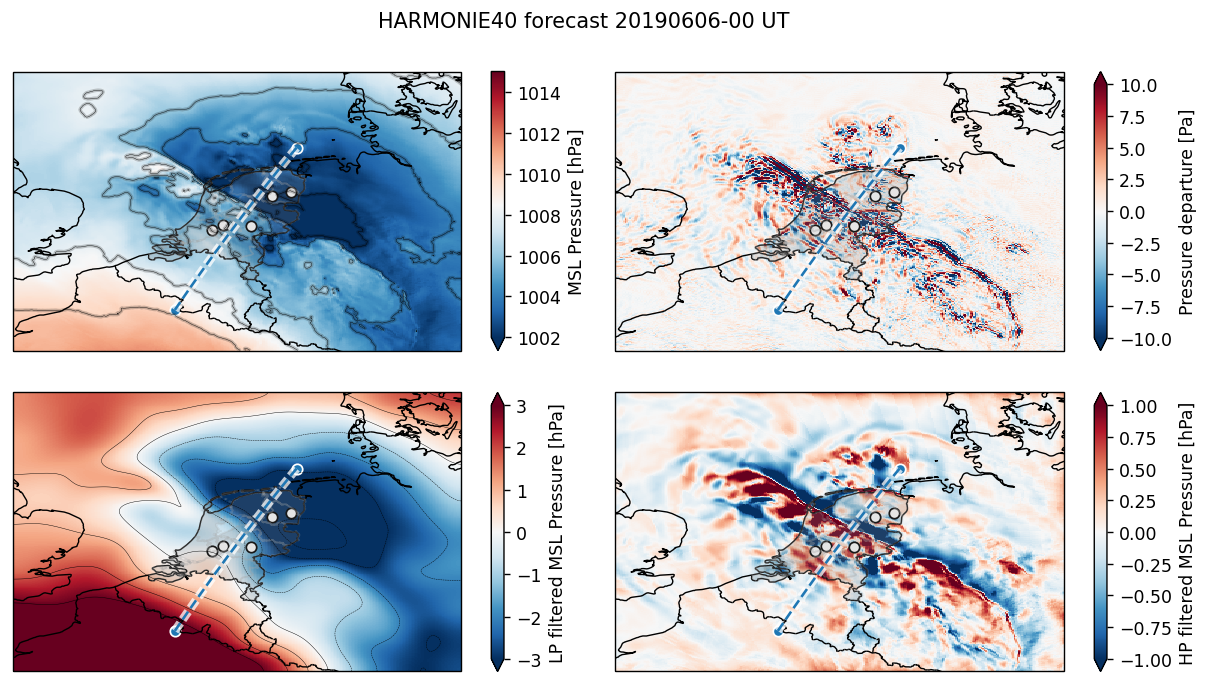

In [19]:
plot_pressure(my_atmos, ds)

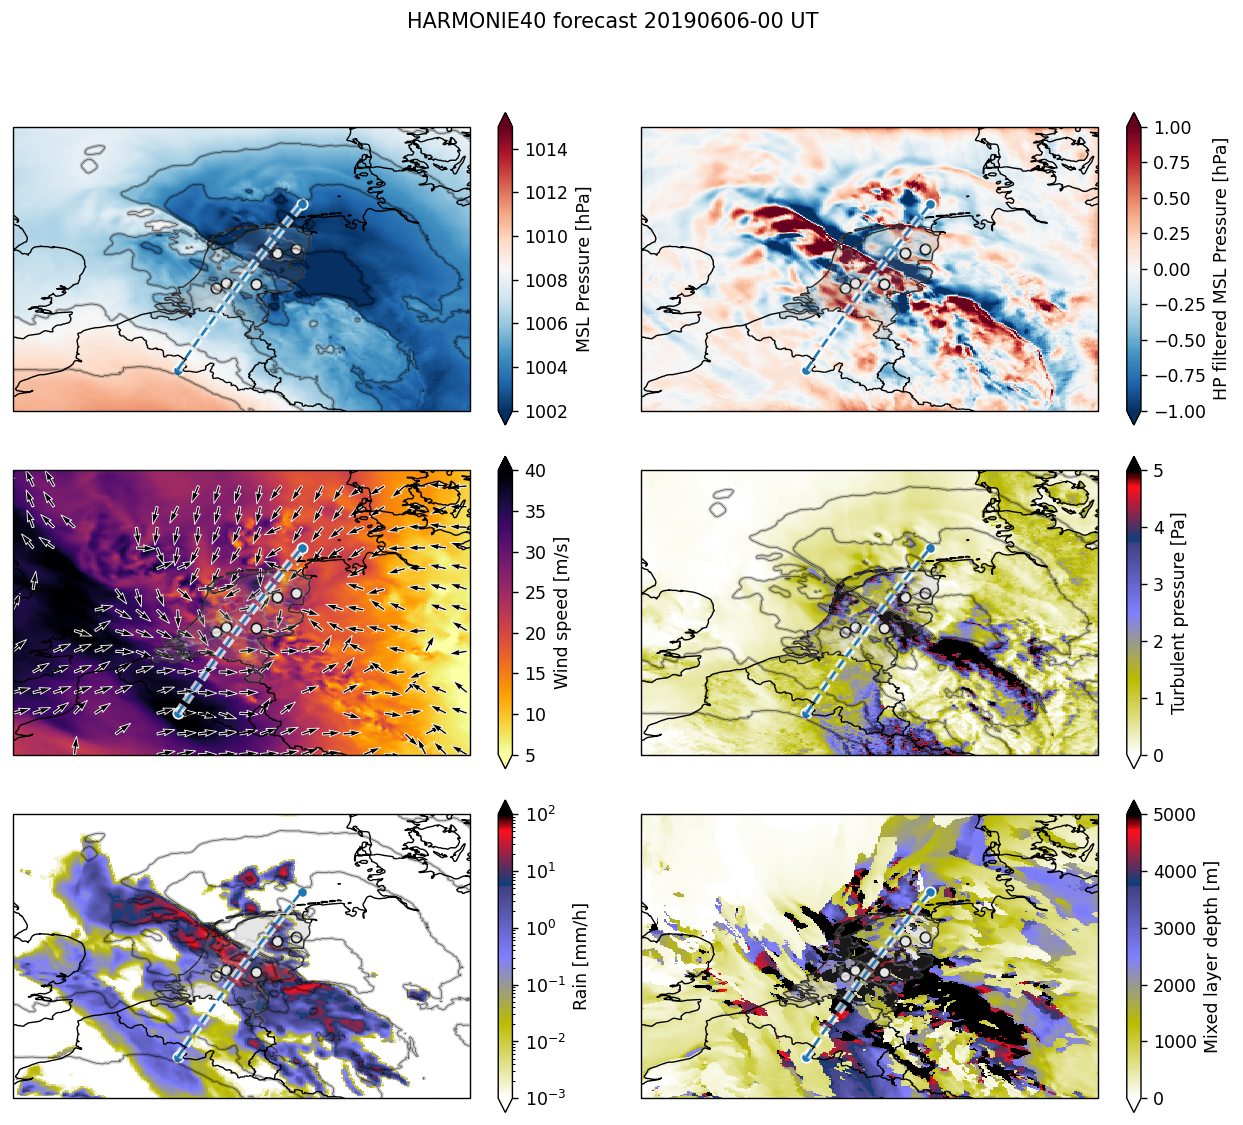

In [20]:
plot_meteo(my_atmos, ds)

## Sample model at locations and write to dataframe

In [21]:
ds_sample = sample_model(ds, df)

In [22]:
ds_sample

<xarray.Dataset>
Dimensions:         (hybrid: 65, site_index: 5)
Coordinates:
    time            datetime64[ns] 2019-06-06
    step            timedelta64[ns] 00:00:00
    valid_time      datetime64[ns] 2019-06-06
    heightAboveSea  int64 0
    longitude       (site_index) float64 4.928 5.176 5.887 6.395 6.866
    latitude        (site_index) float64 51.97 52.1 52.06 52.81 52.91
  * site_index      (site_index) int64 0 1 2 3 4
    site_code       (site_index) object 'NL.CIA' 'NL.DBNI' ... 'NL.EXL'
    site_location   (site_index) object 'Cabauw' 'De Bilt' ... 'Exloo'
Dimensions without coordinates: hybrid
Data variables:
    u               (hybrid, site_index) float64 -17.18 -17.23 ... -4.028 1.746
    v               (hybrid, site_index) float64 0.7133 0.8186 ... 4.714 -0.3799
    pres            (site_index) float64 1.006e+05 1.005e+05 ... 1.002e+05
    ugst            (site_index) float64 4.29 1.574 7.608 -8.183 2.292
    vgst            (site_index) float64 -2.142 -5.455 0.9349 7.984 -0.2725
    mld             (site_index) float64 2.273e+03 5e+03 5e+03 4.617e+03 12.72
    rain            (site_index) float64 0.04513 0.001259 34.46 3.131 0.0
    windgust_speed  (site_index) float64 4.802 5.678 7.666 11.46 2.326
    wind_speed      (hybrid, site_index) float64 17.2 17.25 ... 6.214 1.801
    pres_msl        (site_index) float64 1.006e+03 1.005e+03 ... 1.002e+03
    pres_hp         (site_index) float64 -0.1522 0.008334 0.7227 0.1818 -0.1746
    pres_lp         (site_index) float64 -0.07485 -0.416 -1.343 -3.754 -3.775
    pres_turb       (site_index) float64 0.5578 0.8297 0.7849 3.222 0.05422
    tke_ground      (site_index) float64 0.4528 0.6757 0.6453 2.674 0.04506

In [23]:
t_fcst=(ds_sample.valid_time).dt.strftime('%Y%m%d-%H:00:00').values
print(t_fcst)

20190606-00:00:00


## Process samples that have been produced over loop in separate script

In [24]:
ds = xr.open_dataset('dataset.nc')

In [25]:
ds

<xarray.Dataset>
Dimensions:         (site_index: 5, valid_time: 120)
Coordinates:
    time            (valid_time) datetime64[ns] ...
    step            (valid_time) timedelta64[ns] ...
  * valid_time      (valid_time) datetime64[ns] 2019-06-04 ... 2019-06-08T23:...
    heightAboveSea  int64 ...
    longitude       (site_index) float64 ...
    latitude        (site_index) float64 ...
  * site_index      (site_index) int64 0 1 2 3 4
    site_code       (site_index) object ...
    site_location   (site_index) object ...
Data variables:
    pres            (valid_time, site_index) float64 ...
    ugst            (valid_time, site_index) float64 ...
    vgst            (valid_time, site_index) float64 ...
    mld             (valid_time, site_index) float64 ...
    rain            (valid_time, site_index) float64 ...
    windgust_speed  (valid_time, site_index) float64 ...
    pres_msl        (valid_time, site_index) float64 ...
    pres_hp         (valid_time, site_index) float64 ...
    pres_lp         (valid_time, site_index) float64 ...
    pres_turb       (valid_time, site_index) float64 ...
    tke_ground      (valid_time, site_index) float64 ...

In [26]:
ds.site_location

<xarray.DataArray 'site_location' (site_index: 5)>
array(['Cabauw', 'De Bilt', 'Deelen', 'Dwingeloo', 'Exloo'], dtype=object)
Coordinates:
    heightAboveSea  int64 0
    longitude       (site_index) float64 4.928 5.176 5.887 6.395 6.866
    latitude        (site_index) float64 51.97 52.1 52.06 52.81 52.91
  * site_index      (site_index) int64 0 1 2 3 4
    site_code       (site_index) object 'NL.CIA' 'NL.DBNI' ... 'NL.EXL'
    site_location   (site_index) object 'Cabauw' 'De Bilt' ... 'Exloo'

In [27]:
ds.close()

In [28]:
from obspy.clients.filesystem.sds import Client as sds_client
from obspy.clients.fdsn import Client as fdsn_client
from obspy import UTCDateTime

In [29]:
sds_cl = sds_client('../../aws/data')

In [30]:
t0 = UTCDateTime('2019-06-05T00:00:00')
t1 = UTCDateTime('2019-06-07T00:00:00')
st = sds_cl.get_waveforms('NL','348','*','LDA',starttime=t0, endtime=t1).merge(fill_value='interpolate')
st += sds_cl.get_waveforms('NL','261','*','LDA',starttime=t0, endtime=t1).merge(fill_value='interpolate')

#st.detrend()
#st.resample(10.0)
#st.filter('bandpass', freqmin=5.0e-5, freqmax=0.02, corners=1, zerophase=True)

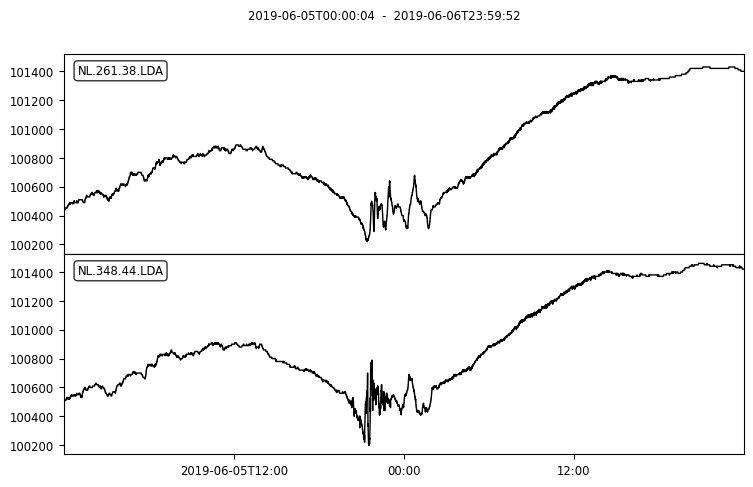

In [31]:
fig = st.plot()

In [32]:
import matplotlib.dates as mdate

# Choose your xtick format string
date_fmt = '%d %b %y\n%H:%M'
# Use a DateFormatter to set the data to the correct format.
date_formatter = mdate.DateFormatter(date_fmt)

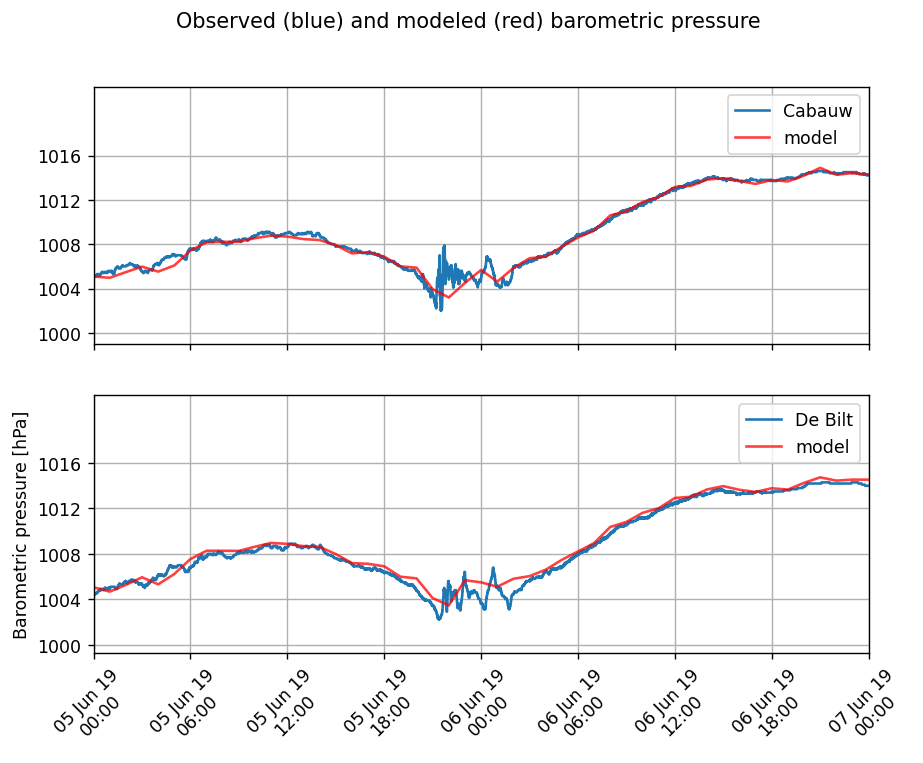

In [33]:
mapping = {'NL.CIA':'348', 'NL.DBNI': '261'}

fig, ax = plt.subplots(len(mapping), 1, sharex=True, figsize=(8,6))

idx = -1
for item in mapping.keys():
    idx += 1
    _ds = ds.where(ds.site_code==item, drop=True)
    tr = st.select(network='NL', station=mapping[item])[0]
    t_obs = tr.times(type='matplotlib')
    p_obs = tr.data / 1e2
    
    t_model = _ds.pres_msl.valid_time
    p_model = _ds.pres_msl.data
    location = str(_ds.site_location.data[0])
    ax[idx].plot(t_obs,p_obs, c='C0', label=location)
    #ax[idx].plot(t_obs_,p_obs_, c='darkblue')
    ax[idx].plot(t_model, p_model, c='r', label='model', alpha=0.75)
    ax[idx].set_xlim(t0.matplotlib_date, t1.matplotlib_date)
    ax[idx].legend()
    ax[idx].grid()
    ax[idx].set_yticks(np.arange(1000,1020,4))

    # Sets the tick labels diagonal so they fit easier.
    #fig.autofmt_xdate(rotation=70)

ax[idx].tick_params(axis='x', rotation=45)
ax[idx].xaxis.set_major_formatter(date_formatter)

ax[idx].set_ylabel('Barometric pressure [hPa]')

fig.suptitle('Observed (blue) and modeled (red) barometric pressure')

fig.savefig('barometer-harmonie.png', facecolor='white')
plt.show()

In [34]:
fdsn_cl = fdsn_client('KNMI')

In [35]:
st = fdsn_cl.get_waveforms('NL', 'DBN01, CIA07, DL01, EXL02, IS311', '*', '*DF', t0, t1, attach_response=True)

In [36]:
st_ = st.copy()

In [37]:
pre_filt = [0.02, 0.05, 5, 10]
st_.remove_response(pre_filt=pre_filt, output='VEL')

5 Trace(s) in Stream:
NL.CIA07.00.HDF | 2019-06-05T00:00:00.000000Z - 2019-06-07T00:00:00.000000Z | 100.0 Hz, 17280001 samples
NL.DBN01.01.HDF | 2019-06-05T00:00:00.000000Z - 2019-06-07T00:00:00.000000Z | 100.0 Hz, 17280001 samples
NL.DL01.00.HDF  | 2019-06-05T00:00:00.000000Z - 2019-06-07T00:00:00.000000Z | 100.0 Hz, 17280001 samples
NL.EXL02.00.HDF | 2019-06-05T00:00:00.000000Z - 2019-06-07T00:00:00.000000Z | 100.0 Hz, 17280001 samples
NL.IS311..BDF   | 2019-06-05T00:00:00.000000Z - 2019-06-07T00:00:00.000000Z | 40.0 Hz, 6912001 samples

In [38]:
try:
    st_.select(station='CIA07')[0].stats['station'] = 'CIA'
except:
    pass

try:
    st_.select(station='DBN01')[0].stats['station'] = 'DBNI'
except:
    pass

try:
    st_.select(station='EXL02')[0].stats['station'] = 'EXL'
except:
    pass

try:
    st_.select(station='DL01')[0].stats['station'] = 'DIA'
except:
    pass

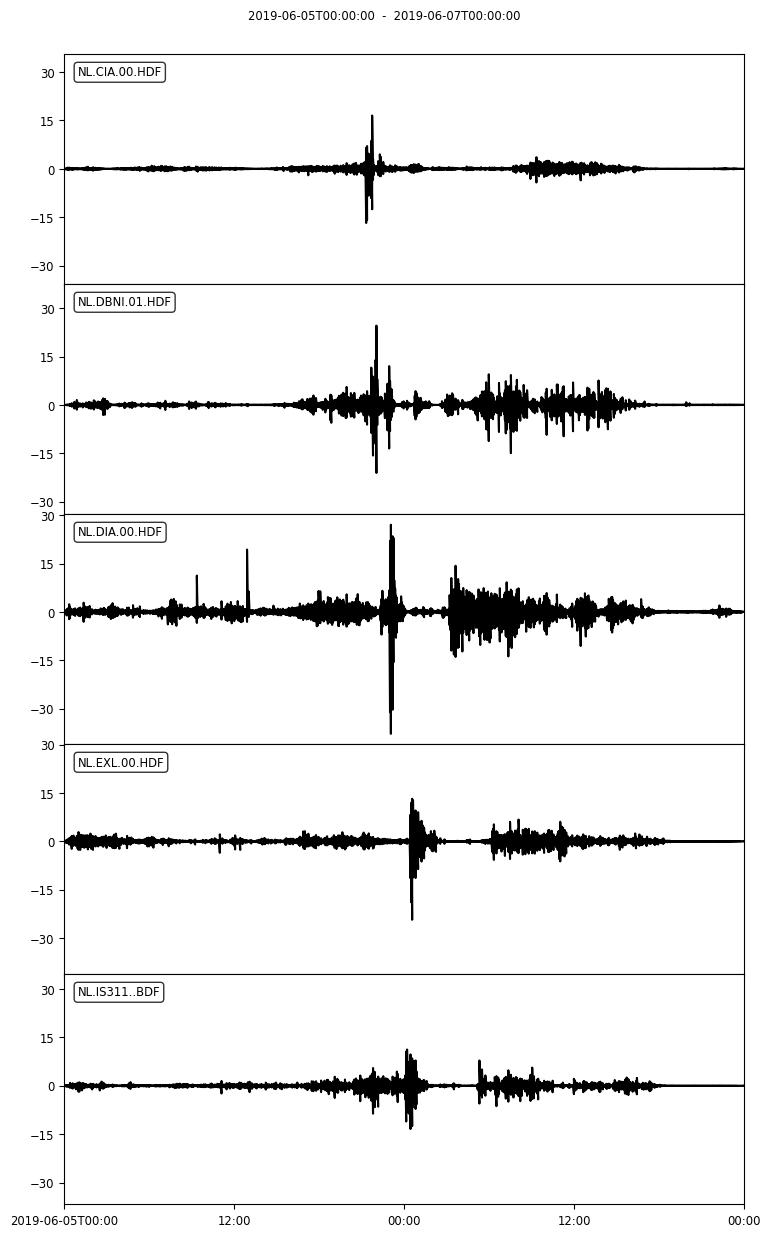

In [39]:
fig = st_.plot()

In [40]:
# def moving_average(x, w):
#     return np.convolve(x, np.ones(w), mode='valid') / w

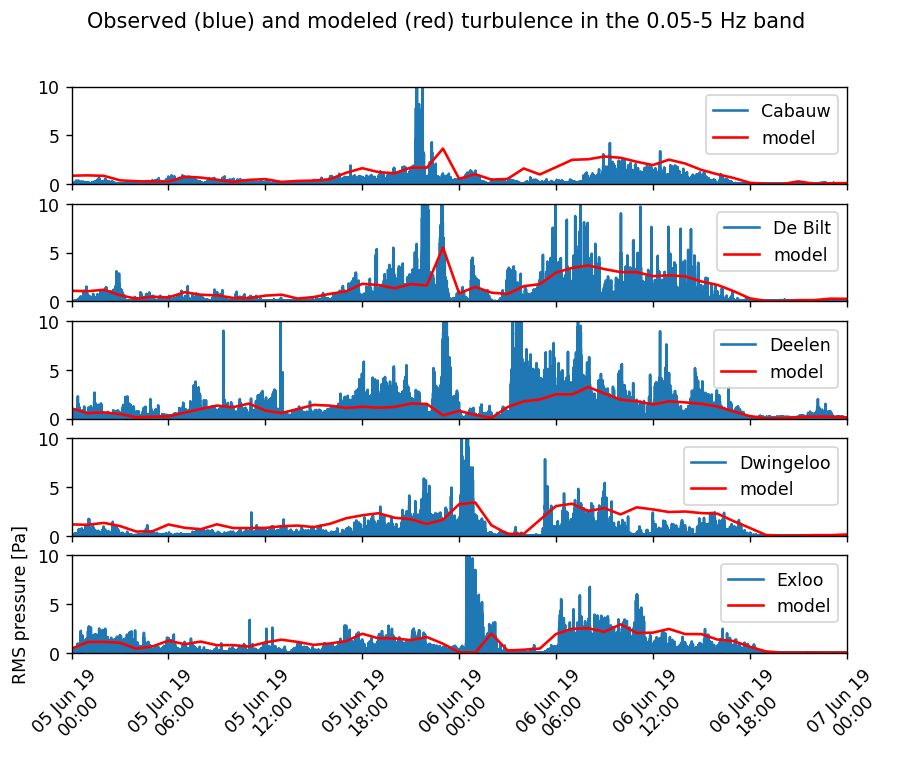

In [41]:
array_list = ['NL.CIA', 'NL.DBNI', 'NL.DIA', 'NL.IS311', 'NL.EXL']
fig, ax = plt.subplots(len(array_list), 1, sharex=True, figsize=(8,6))

#average_sec = 60*10
npt = 100

for idx in range(0,len(array_list)):
    item = array_list[idx]
    _ds = ds.where(ds.site_code==item, drop=True)
    (net, sta) = item.split('.')
    tr = st_.select(network=net, station=sta)[0]
    t_obs = tr.times(type='matplotlib')
    p_obs = np.sqrt(tr.data**2)
#     average_pnts = int(average_sec * tr.stats.sampling_rate)
#     t_obs_ = moving_average(t_obs, average_pnts)
#     p_obs_ = moving_average(p_obs, average_pnts)
    
    t_model = _ds.pres_turb.valid_time
    p_model = _ds.pres_turb.data
    location = str(_ds.site_location.data[0])
    ax[idx].plot(t_obs[::npt], p_obs[::npt], c='C0', label=location)
    #ax[idx].plot(t_obs_,p_obs_, c='darkblue')
    ax[idx].plot(t_model, p_model, c='r', label='model')
    ax[idx].set_xlim(t0.matplotlib_date, t1.matplotlib_date)
    ax[idx].set_ylim(0, 10)
    ax[idx].legend()
    # Sets the tick labels diagonal so they fit easier.
    #fig.autofmt_xdate(rotation=70)

    ax[idx].tick_params(axis='x', rotation=45)
ax[idx].xaxis.set_major_formatter(date_formatter)

ax[idx].set_ylabel('RMS pressure [Pa]')

fig.suptitle('Observed (blue) and modeled (red) turbulence in the 0.05-5 Hz band')

fig.savefig('microbarometer-noise-levels.png', facecolor='white')
plt.show()